In [1]:
import sys
import os
from IPython.display import Image
import pandas as pd
from pathlib import Path


# Replace with the actual path to your pyxations package
package_path = "../pyxations"
sys.path.append(package_path)
import pyxations as pyx
from pyxations import compute_derivatives_for_dataset, dataset_to_bids, Experiment
import os
from pyxations.export import FEATHER_EXPORT, HDF5_EXPORT

# Dataset to BIDS

# Compute derivatives

In [2]:
base_folder = os.path.dirname(os.getcwd())
files_folder_path = os.path.join(base_folder,"tests","data","example_files")

bids_dataset_folder = dataset_to_bids(base_folder,files_folder_path,"example_dataset")

start_msgs = {'search':['beginning_of_stimuli']}
end_msgs= {'search':['end_of_stimuli']}
msg_keywords = ["begin","end","press"]

In [ ]:
# eyelink
derivatives_path = compute_derivatives_for_dataset(bids_dataset_folder,
                                                   dataset_format='eyelink',  
                                                   detection_algorithm='eyelink',
                                                   msg_keywords=msg_keywords, 
                                                   start_msgs=start_msgs, 
                                                   end_msgs=end_msgs)

derivatives_path

In [ ]:
# remodnav
compute_derivatives_for_dataset(
    bids_dataset_folder, 'eyelink', detection_algorithm= 'remodnav', msg_keywords=msg_keywords, 
    start_msgs=start_msgs, end_msgs=end_msgs, overwrite=True,
    max_pso_dur=0, min_fix_dur=0, sac_max_vel=999, savgol_length= 0.195,
)

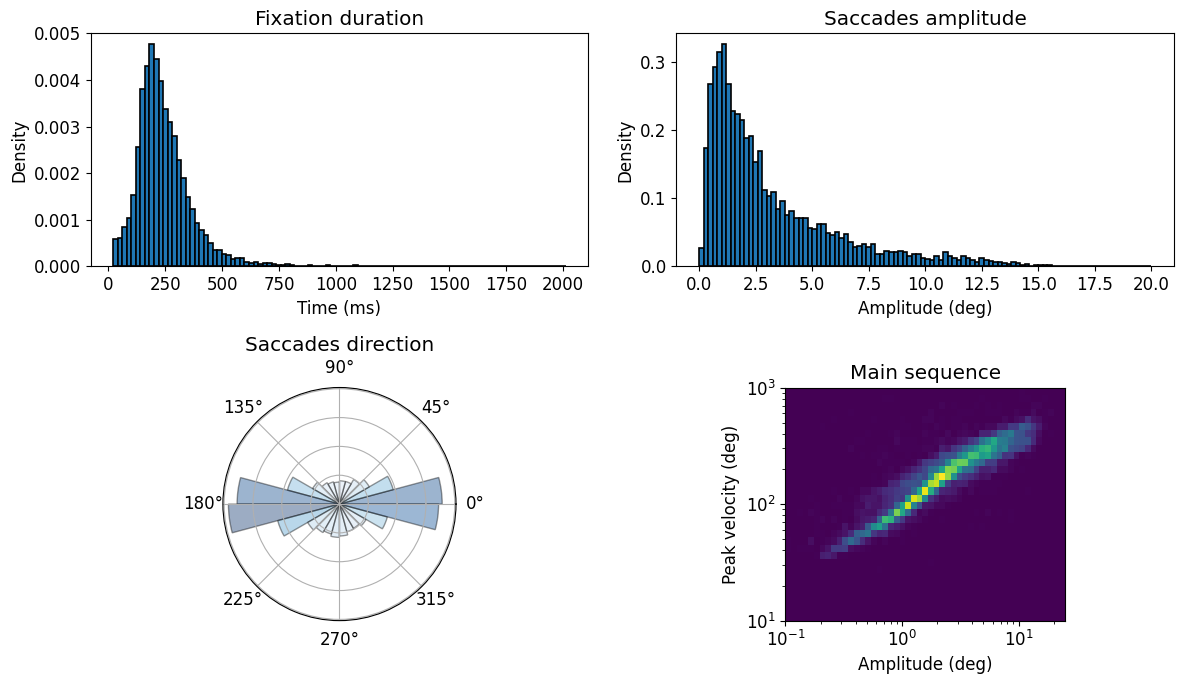

In [4]:
exp = pyx.Experiment(bids_dataset_folder)
exp.load_data("eyelink")

# Some plots
exp.plot_multipanel(True)

In [8]:
exp.subjects

{'0001': Subject = '0001', Experiment = 'example_dataset',
 '0002': Subject = '0002', Experiment = 'example_dataset',
 '0003': Subject = '0003', Experiment = 'example_dataset',
 '0004': Subject = '0004', Experiment = 'example_dataset'}

In [18]:
exp.subjects['0001'].sessions

{'second': Session = 'second', Subject = '0001', Experiment = 'example_dataset'}

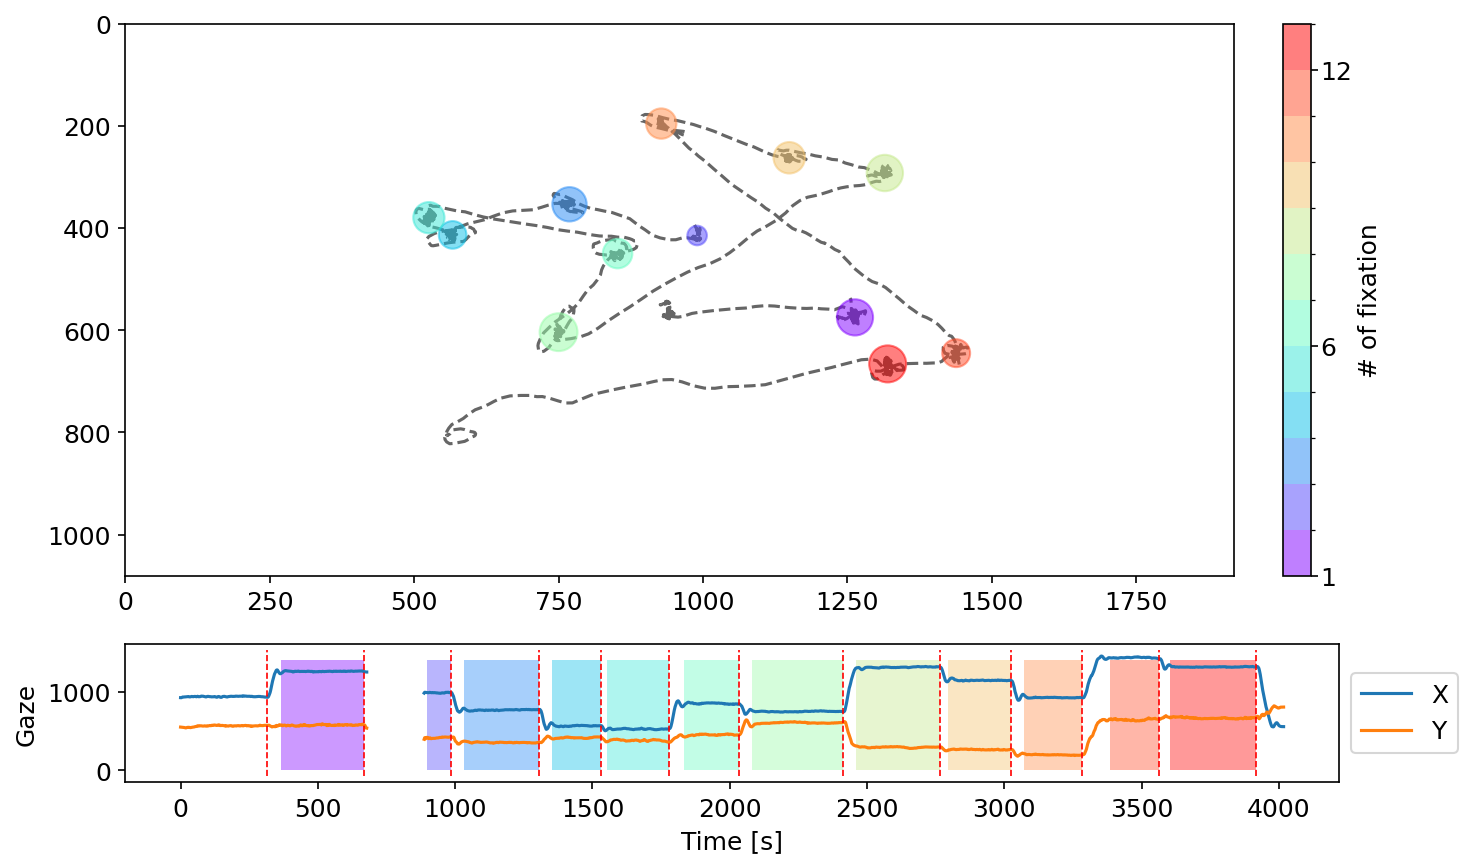

In [30]:
exp.subjects['0001'].get_trial(session_id='second', trial_number=3).plot_scanpath(1080, 1920)

In [24]:
# Retrieve data for specific trial
exp.get_trial(subject_id='0001', session_id='second', trial_number=1).fixations()

index,eye,tStart,tEnd,duration,xAvg,yAvg,pupilAvg,Line_number,Eyes_recorded,Rate_recorded,bad,phase,trial_number,trial_label
i64,str,f64,f64,i64,f64,f64,i64,i64,str,f64,bool,str,i64,str
89,"""R""",377.0,715.0,339,1044.5,630.0,672,50982,"""LR""",1000.0,false,"""search""",1,""""""
90,"""R""",748.0,955.0,208,833.0,702.2,679,51230,"""LR""",1000.0,false,"""search""",1,""""""
91,"""R""",1769.0,2048.0,280,469.5,581.3,726,52342,"""LR""",1000.0,false,"""search""",1,""""""
92,"""R""",2084.0,2308.0,225,550.9,608.8,740,52607,"""LR""",1000.0,false,"""search""",1,""""""
93,"""R""",2322.0,2683.0,362,539.2,626.0,772,52990,"""LR""",1000.0,false,"""search""",1,""""""
94,"""R""",2761.0,3045.0,285,1313.2,647.6,714,53360,"""LR""",1000.0,false,"""search""",1,""""""
95,"""R""",3055.0,3366.0,312,1337.0,661.2,707,53690,"""LR""",1000.0,false,"""search""",1,""""""


## Saccades

In [9]:
remodnav_sacc_path = derivatives_path / "sub-0001" / "ses-second" / "remodnav_events" / "sacc.feather"
eyelink_sacc_path = derivatives_path / "sub-0001" / "ses-second" / "eyelink_events" / "sacc.feather"


In [ ]:
df_remodnav = pd.read_feather(remodnav_sacc_path)
df_remodnav

In [ ]:
df_eyelink = pd.read_feather(eyelink_sacc_path)
df_eyelink

In [58]:
import matplotlib.pyplot as plt

def plot_comparison(df_eyelink, df_remodnav, trial:int=None):
    if trial:
        df_eyelink = df_eyelink[df_eyelink['trial_number']== trial]
        df_remodnav = df_remodnav[df_remodnav['trial_number']== trial]
    
    # Plot settings
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot segments for df1
    for start, end in zip(df_eyelink["tStart"], df_eyelink["tEnd"]):
        #ax.plot([start, end], [1, 1], color="blue", marker="o", label="Series 1" if start == df_eyelink["tStart"][0] else "")
        ax.plot([start, end], [1, 1], color="blue", marker="o", label="Eyelink" )


        # Plot segments for df2
    for start, end in zip(df_remodnav["tStart"], df_remodnav["tEnd"]):
        #ax.plot([start, end], [2, 2], color="red", marker="o", label="Series 2" if start == df_remodnav["tStart"][0] else "")
        ax.plot([start, end], [2, 2], color="red", marker="x", label="Remodnav")

    # Customize the y-axis to label the series
    ax.set_yticks([1, 2])
    ax.set_yticklabels(["Eyelink", "Remodnav"])

    # Add labels and title
    ax.set_xlabel("Time")
    ax.set_ylabel("Series")
    title = "Segment Plot for detection algorithms"
    if trial:
        title += f' Trial: {trial}'
    ax.set_title(title)

    # Show the legend
    #ax.legend()

    # Show the plot
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [59]:
def plot_screen(df, another_df, trial_no=None):
    if trial_no:
        df = df[df['trial_number']== trial_no]
        another_df = another_df[another_df['trial_number']== trial_no]

        # Create a plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each segment
    for _, row in df.iterrows():
        ax.plot([row["xStart"], row["xEnd"]], [row["yStart"], row["yEnd"]], marker="o", color="red", label=f"Segment A: {_+1}")

    # Plot each segment
    for _, row in another_df.iterrows():
        ax.plot([row["xStart"], row["xEnd"]], [row["yStart"], row["yEnd"]], marker="x", color="blue", label=f"Segment B: {_+1}")
        
        
    # Add labels and title
    ax.set_title("Segments Plot")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()  # Show legend for each segment

    # Show grid
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show the plot
    plt.show()

In [ ]:
plot_comparison(df_eyelink, df_remodnav, 1)

In [ ]:
plot_comparison(df_eyelink, df_remodnav, 2)

In [ ]:
plot_comparison(df_eyelink, df_remodnav, 50)

In [ ]:
plot_screen(df_eyelink, df_remodnav, 1)

In [ ]:
plot_screen(df_eyelink, df_remodnav, 50)

# Fixations

In [65]:
remodnav_fix_path = derivatives_path / "sub-0001" / "ses-second" / "remodnav_events" / "fix.feather"
eyelink_fix_path = derivatives_path / "sub-0001" / "ses-second" / "eyelink_events" / "fix.feather"

df_fix_remodnav = pd.read_feather(remodnav_fix_path)
df_fix_eyelink = pd.read_feather(eyelink_fix_path)

In [ ]:
plot_comparison(df_fix_eyelink, df_fix_remodnav, 1)

In [ ]:
plot_comparison(df_fix_eyelink, df_fix_remodnav, 50)